# **PREPARATION**

In [1]:
#Install transformers dari Hugging Face
!pip install -q transformers

     |████████████████████████████████| 2.9 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 40.1 MB/s 
     |████████████████████████████████| 3.3 MB 34.6 MB/s 
     |████████████████████████████████| 895 kB 41.0 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 


In [2]:
#Clone repository IndoNLU
!git clone https://github.com/baysetyo13/indonlu

Cloning into 'indonlu'...
remote: Enumerating objects: 444, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 444 (delta 24), reused 41 (delta 20), pack-reused 394
Receiving objects: 100% (444/444), 4.83 MiB | 13.67 MiB/s, done.
Resolving deltas: 100% (219/219), done.


In [4]:
import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer

from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader

In [5]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
## menghitung jumlah parameter   
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

## untuk mendapatkan learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## mengubah dari metrics evaluation kedalam string
def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [6]:
# Set random seed
set_seed(26092020)

In [7]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
#tokenizer
text = "terima kasih pak gubernur atas pujiannya"

token = tokenizer.tokenize(text)
encoding = tokenizer.encode(text)
decoding = tokenizer.decode(encoding)
encoding_input = tokenizer(text)

print(token)
print(encoding)
print(decoding)
print(encoding_input)

['terima', 'kasih', 'pak', 'gubernur', 'atas', 'pujian', '##nya']
[2, 1788, 1338, 556, 3256, 441, 10291, 57, 3]
[CLS] terima kasih pak gubernur atas pujiannya [SEP]
{'input_ids': [2, 1788, 1338, 556, 3256, 441, 10291, 57, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
text1 = "jangan lupa bahagia"
text2 = "Air merupakan salah satu sumber kehidupan yang penting"

encoded_text1 = tokenizer(text1)["input_ids"]
encoded_text2 = tokenizer(text2)["input_ids"]
padded_sequences = tokenizer([text1, text2], padding=True)
print(padded_sequences)

{'input_ids': [[2, 843, 2516, 4771, 3, 0, 0, 0, 0, 0], [2, 514, 407, 427, 282, 1099, 1253, 34, 906, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
config

BertConfig {
  "_name_or_path": "indobenchmark/indobert-base-p1",
  "_num_labels": 5,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

# **PREPROCESSING**

In [ ]:
import pandas as pd

file = 'https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/re_dataset.csv'
df = pd.read_csv(file, encoding='ISO-8859-1')

file2 = 'https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/new_kamusalay.csv'
alay_dict = pd.read_csv(file2, encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

In [ ]:
print("Shape: ", df.shape)
df.head(5)

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [ ]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import numpy as np
def show_pie(label, df, legend_title) :
    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect='equal'))

    labels = [x.split()[-1] for x in label]

    def func(pct, allvals):
        absolute = int(round(pct/100.*np.sum(allvals)))
        return "{:.1f}% ({:d})".format(pct, absolute)

    wedges, texts, autotexts = ax.pie(df, autopct=lambda pct: func(pct, df), 
                                      textprops=dict(color="w"))

    ax.legend(wedges, labels,
              title= legend_title,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    
    
    plt.setp(autotexts, size=10, weight="bold")
    ax.set_title("Perbandingan Label")
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


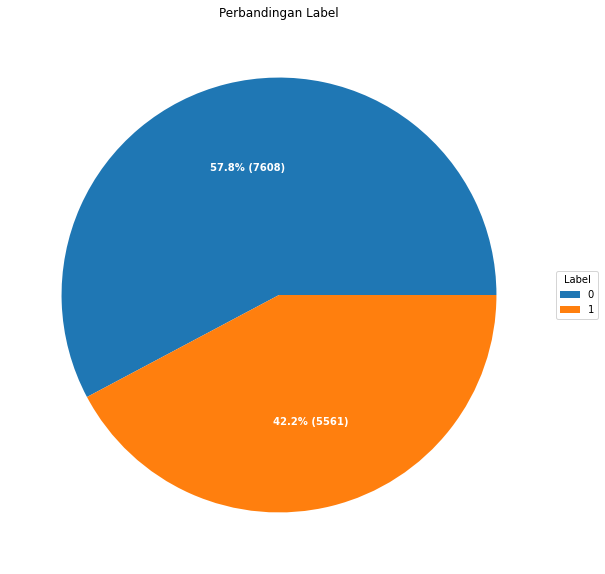

In [ ]:
HSlabel = df.HS.value_counts()
label = ['0', '1']
count_data = [HSlabel]


show_pie(label, count_data, "Label")

**Alay Dict**

In [ ]:
print("Shape: ", alay_dict.shape)
alay_dict.head(10)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [ ]:
import re
def remove_unnecessary_char(text):
    url_regex = ('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+)||(http\S+))')
    emoticon_byte_regex = r'\s*(?:\\x[A-Fa-f0-9]{2})+'

    text = re.sub(url_regex, '', text) # Remove every url
    text = re.sub('@[\w\-]+', '', text) # Remove Mentions
    text = re.sub(' URL',' ',text) # Remove word URL
    text = re.sub(' url', ' ',text) # Remove word url
    text = re.sub(r'\\n',' ', text) # Remove every '\n' 
    text = re.sub('RT','', text) # Remove every retweet symbol
    text = re.sub('USER','', text) # Remove every user
    text = re.sub('\\+', ' ', text)
    text = re.sub(emoticon_byte_regex, '', text) # Remove emoticon bytes
    text = re.sub('[^0-9a-zA-Z]', ' ', text) #Remove punctuation
    text = re.sub(' +', ' ', text) # Remove extra spaces 
    text = re.sub('\s+', ' ', text)
    return text


# Example
text = 'RT USER: Ayoo jaga      keutuhan NKRI!!! Tangkap Penista 34634Agama!!! #StopKriminalisasiUlama https:\/\/t.co\/dxIDQ4ZQHV'
print("Example") 
print("before: ", text)
print("after : ", remove_unnecessary_char(text))


df['text'] = df['Tweet'].apply(remove_unnecessary_char)
df.text = df.text.str.strip()
df[['Tweet', 'text']].sample(10)

Example
before:  RT USER: Ayoo jaga      keutuhan NKRI!!! Tangkap Penista 34634Agama!!! #StopKriminalisasiUlama https:\/\/t.co\/dxIDQ4ZQHV
after :   Ayoo jaga keutuhan NKRI Tangkap Penista 34634Agama StopKriminalisasiUlama 


,Tweet,text
6613,"Ketika anda lihat setan jangan lah anda takut,...",Ketika anda lihat setan jangan lah anda takut ...
3036,RT USER: Enak nya habis ngentot dimainin pejuh...,Enak nya habis ngentot dimainin pejuhnya
3929,Sampai detik ini si USER masih tetap bertahan ...,Sampai detik ini si masih tetap bertahan denga...
6424,USER USER dikatain monyet',dikatain monyet
10768,Teman tapi kampret semua ini namanya :(( URL,Teman tapi kampret semua ini namanya
6734,Abis kerja pkl 11 sampai sekarang tk blk rmh n...,Abis kerja pkl 11 sampai sekarang tk blk rmh n...
1844,USER: Betapa Tubuh di Indonesia itu terkepung ...,Betapa Tubuh di Indonesia itu terkepung dan te...
5105,Yusril: Kelompok Islam Tertindas di Era Jokowi...,Yusril Kelompok Islam Tertindas di Era Jokowi ...
647,"""Keanekaragaman budaya, suku, agama, itulah se...",Keanekaragaman budaya suku agama itulah sesung...
1539,Koalisi tapi pakai hati. Cuci tangan sambil be...,Koalisi tapi pakai hati Cuci tangan sambil ber...


In [ ]:
# Lowercase letters
def lowercase(text):
  text = text.lower()
  return text
  
df['text'] = df['text'].apply(lowercase)
df[['Tweet', 'text']].head()

,Tweet,text
0,- disaat semua cowok berusaha melacak perhatia...,disaat semua cowok berusaha melacak perhatian ...
1,RT USER: USER siapa yang telat ngasih tau elu?...,siapa yang telat ngasih tau elu edan sarap gue...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",41 kadang aku berfikir kenapa aku tetap percay...
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,aku itu aku ku tau matamu sipit tapi diliat da...
4,USER USER Kaum cebong kapir udah keliatan dong...,kaum cebong kapir udah keliatan dongoknya dari...


In [ ]:
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])


df['text'] = df['text'].apply(normalize_alay)
df[['Tweet', 'text']].head()

,Tweet,text
0,- disaat semua cowok berusaha melacak perhatia...,di saat semua cowok berusaha melacak perhatian...
1,RT USER: USER siapa yang telat ngasih tau elu?...,siapa yang telat memberi tau kamu edan sarap g...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",41 kadang aku berpikir kenapa aku tetap percay...
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,aku itu aku ku tau matamu sipit tapi dilihat d...
4,USER USER Kaum cebong kapir udah keliatan dong...,kaum cebong kafir sudah kelihatan dongoknya da...


In [ ]:
def classify(hs):
    retval = ""
    if int(hs) == 1:
        retval = 'HS'
    else:
        retval = 'Non_HS'
    return retval

In [ ]:
df['hs_class'] = df['HS'].apply(classify)
df[['text', 'hs_class']].sample(10)

,text,hs_class
8416,laskar liar yang terdiri dari para penjahat ke...,Non_HS
3165,jayalah korupsi keinginan untuk bubarkan semac...,HS
6519,beda tingkat intelektualitasnya meskipun berte...,HS
6318,tai adalah saat gue biasa saja dia baik banget...,Non_HS
11116,terciduk juga nih kunyuk proses hukum saja tid...,HS
5001,berkebalikan dengan semangat upah 1960 orienta...,Non_HS
11467,berengsek lagunya mantaaapppp,Non_HS
10501,pabrik saja mereka sweeping karena tidak mengi...,HS
6949,banyak siapanya buaya,Non_HS
7697,salut to the master banyak dewan yang tak puny...,Non_HS


In [ ]:
df = df[['text', 'hs_class']]
df.to_csv('DatasetCleaned.csv', index = False)
df.sample(5)

,text,hs_class
2092,indonesia diyakini akan menjadi negara yang se...,Non_HS
5054,kalau felix pilih agama tinggalkan negara ini,HS
5805,tidak perlu berhutang demi mendapat 51 saham f...,HS
3074,ya kan gue memang sipit,Non_HS
8573,super gubernur anies bertemu erdogan,Non_HS


In [ ]:
df = pd.read_csv('DatasetCleaned.csv')

df = df[df['text'].notna()]

print("Shape: ", df.shape)
df.head(10)

df.to_csv('DatasetUnbalanced.csv', index=False)

Shape:  (13123, 2)


In [ ]:
df = pd.read_csv('DatasetUnbalanced.csv')

In [ ]:
# df_balanced = [ df.loc[df.label == 0].sample(10), df.loc[df.lable == 1].sample(10) ]
df_class1 = df.loc[df.hs_class == 'HS']
size_class1 = df_class1.shape[0]
df_class0 = df.loc[df.hs_class == 'Non_HS'].sample(size_class1)

df_balanced = [df_class0, df_class1]
df = pd.concat(df_balanced)

df.to_csv('DatasetBalanced.csv', index = False)
# Report the number of sentences.
print('Number of balanced training sentences: {:,}\n'.format(df.shape[0]))

Number of balanced training sentences: 11,106



In [ ]:
# Train Test valid Split dengan rasio 80% train, 10% test dan 10% valid
import numpy as np
import pandas as pd

df = pd.read_csv("DatasetBalanced.csv")

train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.8*len(df)), int(.9*len(df))])
              
train.to_csv('DataTrain.csv', index=False)
validate.to_csv('DataVal.csv', index=False)
test.to_csv('DataTest.csv', index=False)

#Load Dataset

In [9]:
train_dataset_path = 'DataTrain.csv'
valid_dataset_path = 'DataVal.csv'
test_dataset_path = 'DataTest.csv'

In [10]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

In [11]:
train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=2, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)  
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(24224, 3028, 3028)

In [ ]:
len(train_loader), len(valid_loader), len(test_loader)

(757, 95, 95)

In [12]:
#label index
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'Non_HS': 0, 'HS': 1}
{0: 'Non_HS', 1: 'HS'}


In [ ]:
text = 'terima kasih pak gubernur atas pujiannya'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: terima kasih pak gubernur atas pujiannya | Label : Non_HS (54.254%)


#Fine Tuning & Evaluation

In [13]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [ ]:
 train_loss_lists = []
 train_acc_lists = []
 eval_loss_lists = []
 eval_acc_lists = []
 
 # Train
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    train_acc_lists.append(metrics['ACC'])
    current_train_loss = round(total_train_loss/(i+1), 4)
    train_loss_lists.append(current_train_loss)

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    eval_acc_lists.append(metrics['ACC'])
    current_eval_loss = round(total_loss/(i+1), 4)
    eval_loss_lists.append(current_eval_loss)
    

(Epoch 1) TRAIN LOSS:0.4575 LR:0.00000300: 100%|██████████| 329/329 [03:04<00:00,  1.78it/s]


(Epoch 1) TRAIN LOSS:0.4575 ACC:0.78 F1:0.77 REC:0.77 PRE:0.78 LR:0.00000300


VALID LOSS:0.3552 ACC:0.84 F1:0.84 REC:0.85 PRE:0.84: 100%|██████████| 41/41 [00:08<00:00,  4.75it/s]


(Epoch 1) VALID LOSS:0.3552 ACC:0.84 F1:0.84 REC:0.85 PRE:0.84


(Epoch 2) TRAIN LOSS:0.3489 LR:0.00000300:  14%|█▍        | 46/329 [00:26<02:35,  1.82it/s]

[Text(0.5, 0, 'Epoch 5')]

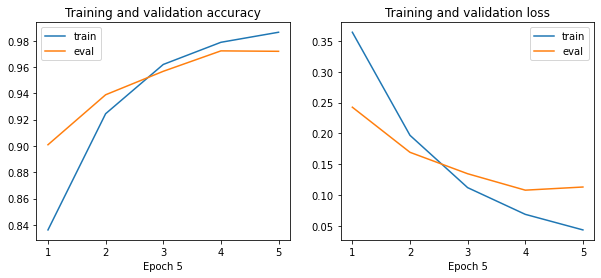

In [ ]:
import matplotlib.pyplot as plt

fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(10, 4))
epoch = [1,2,3,4,5]
plt1.plot(epoch, train_acc_lists, label='train')
plt1.plot(epoch, eval_acc_lists, label='eval')
plt1.set_title('Training and validation accuracy')
plt1.legend()
plt1.set(xlabel='Epoch 5')

plt2.plot(epoch, train_loss_lists, label='train')
plt2.plot(epoch, eval_loss_lists, label='eval')
plt2.set_title('Training and validation loss')
plt2.legend()
plt2.set(xlabel='Epoch 5')

In [ ]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

print(df)

100%|██████████| 23/23 [00:03<00:00,  7.33it/s]

     index   label
0        0  Non_HS
1        1      HS
2        2      HS
3        3  Non_HS
4        4  Non_HS
..     ...     ...
708    708      HS
709    709      HS
710    710      HS
711    711      HS
712    712      HS

[713 rows x 2 columns]


In [ ]:
pred = pd.read_csv('pred.txt')

In [ ]:
daftar_prediksi = []

for i in pred['label'] : 
  if i == 'Non_HS': 
    daftar_prediksi.append(0)
  else :
    daftar_prediksi.append(1)


In [ ]:
data_test = pd.read_csv('DataTestInt.csv')

Accuracy score is 74%.

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       453
           1       0.59      0.99      0.74       260

    accuracy                           0.74       713
   macro avg       0.79      0.80      0.74       713
weighted avg       0.84      0.74      0.74       713


Confusion Matrix:


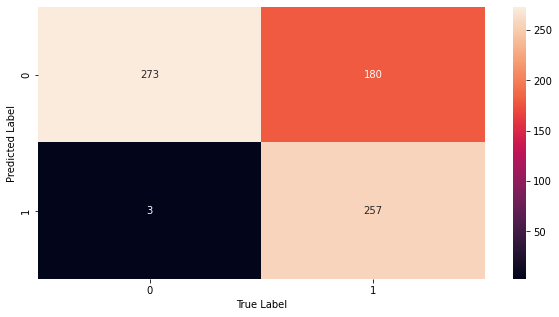

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

accuracy = accuracy_score(data_test['hs_class'], daftar_prediksi) * 100
print("Accuracy score is {}%." .format(round(accuracy),1))
print()
print("Classification Report:")
print(classification_report(data_test['hs_class'], daftar_prediksi))

print("\nConfusion Matrix:")
f, ax = plt.subplots(figsize=(10,5))
sns.heatmap(confusion_matrix(data_test['hs_class'], daftar_prediksi), annot=True, fmt=".0f", ax=ax)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()

In [ ]:
text = 'terima kasih pak gubernur atas pujiannya'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: terima kasih pak gubernur atas pujiannya | Label : Non_HS (99.812%)


In [ ]:
print(logits)

tensor([[ 3.4212, -2.8559]], device='cuda:0')


In [ ]:
print(torch.topk(logits, 1))

torch.return_types.topk(
values=tensor([[3.4212]], device='cuda:0'),
indices=tensor([[0]], device='cuda:0'))


In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


In [ ]:
import pickle

# saving
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls -l --block-size=K ./model_save/

total 487040K
-rw-r--r-- 1 root root      1K Aug 29 17:20 config.json
-rw-r--r-- 1 root root 486188K Aug 29 17:20 pytorch_model.bin
-rw-r--r-- 1 root root      1K Aug 29 17:20 special_tokens_map.json
-rw-r--r-- 1 root root      1K Aug 29 17:44 tokenizer_config.json
-rw-r--r-- 1 root root    612K Aug 29 17:52 tokenizer.pkl
-rw-r--r-- 1 root root    224K Aug 29 17:20 vocab.txt


In [ ]:
jumlah_0_asli = 0
jumlah_1_asli = 0

for i in data_test['hs_class'] :
  if i == 0 :
    jumlah_0_asli += 1
  else :
    jumlah_1_asli += 1

print(jumlah_0_asli)
print(jumlah_1_asli)

750
563


In [ ]:
jumlah_0_pred = 0
jumlah_1_pred = 0

for i in daftar_prediksi :
  if i == 0 :
    jumlah_0_pred += 1
  else :
    jumlah_1_pred += 1

print(jumlah_0_pred)
print(jumlah_1_pred)

753
560


[]

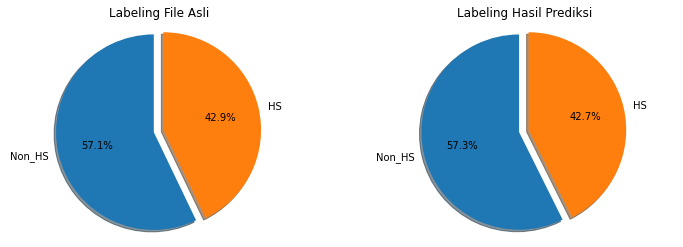

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# File Asli
labels = 'Non_HS', 'HS'
sizes = [jumlah_0_asli, jumlah_1_asli]
explode = (0.1, 0)

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Labeling File Asli')

#Hasil Prekdiksi
labels = 'Non_HS', 'HS'
sizes = [jumlah_0_pred, jumlah_1_pred]
explode = (0.1, 0)

ax2.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')
ax2.set_title('Labeling Hasil Prediksi')

ax1.plot()
ax2.plot()